In [38]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np
import scipy as sp
from numpy.random import rand
import matplotlib.pyplot as plt
import time
import scipy.linalg as la
from math import prod
from functools import cache, lru_cache
import pickle


In [39]:
#a=4.0232/2
a=1
N=1
s=1
m=1
A=1
J=N*m
MHz = 1e6
kHz = 1e3
us = 1e-6
T = N/(A*m)
mu0 = 4*np.pi*1e-7 * (N/A**2)
hbar = 1.054571817 * 1e-34 * (J*s)
gammaF = 2*np.pi * 40.078 * (MHz/T) # spin 1/2
gammaE = 2*np.pi * 28024.9514242 * (MHz/T) # spin 1/2 
gammaLi = 2*np.pi * 16.546 * (MHz/T) # spin 3/2

# coupling strengths in Hz * A**3
Jf = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaF**2 * (10**10)**3
Jlif = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaLi*gammaF * (10**10)**3

In [40]:

def flatten(xsss):
    return [x for xss in xsss for xs in xss for x in xs]

def expected_nodes(r0):
    return 4*r0**3+6*r0**2+3*r0+1

def hop_prob(J,detuning):
    return 1/(1+4*(detuning/J)**2)

@cache
def mean_hopping_prob(sigma,J=1):
    y = J / (4 * sigma)
    return y * np.sqrt(np.pi) * np.exp(y**2) * sp.special.erfc(y)

In [41]:
expected_nodes(14)

12195

In [42]:
expected_nodes(6)

1099

In [43]:
expected_nodes(12)

7813

In [44]:
def grid_graph_2d(L):
    r"""
    Returns a 2d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b)
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L,i+1+j*L,None) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L,i+(j+1)*L,None) for j in range(L-1) for i in range(L)])
    return G

def grid_graph_3d(L):
    r"""
    Returns a 3d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b,c). Only neartest neighbor bonds are included
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j,k) for k in range(L) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i+1)+j*L+k*L**2,None) for k in range(L) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+(j+1)*L+k*L**2,None) for k in range(L) for j in range(L-1) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+j*L+(k+1)*L**2,None) for k in range(L-1) for j in range(L) for i in range(L)])
    return G

def square_grid_graph(L,dim=2):
    r"""
    Generate a square graph in dimension d with side length L
    """
    G=rx.generators.path_graph(L)
    Gnew=rx.generators.path_graph(L)
    for _ in range(dim-1):
        G, hold = rx.cartesian_product(Gnew,G)
    return G

In [45]:
nn_adjacency = [np.array([alpha*a, beta*a,0]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([alpha*a,0,beta*a]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([0,alpha*a,beta*a]) for alpha in (-1,1) for beta in (-1,1)]

nnn_adjacency = [a*alpha*(np.array([1,1,1])+ei) for alpha in (-1,1) for ei in np.identity(3)]

nnnn_adjacency = [a*alpha*(np.array([1,1,1])-3*ei) for alpha in (-1,1) for ei in np.identity(3)]

n5_adjacency = [a*alpha*np.array([1,1,1]) for alpha in (-1,1)]

n6_adjacency = [2*a*np.array([alpha, beta,0]) for alpha in (-1,1) for beta in (-1,1)]
n6_adjacency += [2*a*np.array([alpha,0, beta]) for alpha in (-1,1) for beta in (-1,1)]
n6_adjacency += [2*a*np.array([0, alpha, beta]) for alpha in (-1,1) for beta in (-1,1)]

n7_adjacency = [2*a*alpha*(np.array([1,1,1])-2*ei) for alpha in (-1,1) for ei in np.identity(3)]
n7_adjacency += [a*np.array([alpha,-alpha,2*beta]) for alpha in (-1,1) for beta in (-1,1)]
n7_adjacency += [a*np.array([alpha,2*beta,-alpha]) for alpha in (-1,1) for beta in (-1,1)]
n7_adjacency += [a*np.array([2*beta,alpha,-alpha]) for alpha in (-1,1) for beta in (-1,1)]

def lif_f_sublattice(r0,a=1):
    r"""
    Generate an array containing all of the positions of fluorine atoms in a LiF lattice which
    extends from -r0 to r0 in all directions. If r0 is even, this contains the point (0,0,0),
    otherwise it does not.
    
    This is quite fast compared to implementations using python list comprehension
    """
    odds = np.array(range(-r0, r0+1, 2))
    evens = np.array(range(-r0+1, r0+1, 2))

    odds_grid = np.array(np.meshgrid(odds, odds, odds)).T.reshape(-1, 3)
    evens_grid = np.array(np.meshgrid(evens, evens, odds)).T.reshape(-1, 3)
    evens_grid2 = np.array(np.meshgrid(evens, odds, evens)).T.reshape(-1, 3)
    odds_grid2 = np.array(np.meshgrid(odds, evens, evens)).T.reshape(-1, 3)

    return np.vstack((odds_grid, evens_grid, evens_grid2, odds_grid2)) * a

def generate_fcc(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    f_atom_pos = lif_f_sublattice(r0,a)
    
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,1)
                counter += 1
                if counter == len(nn_adjacency):
                    break
                
    return G


def generate_fcc_nnn(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    f_atom_pos = lif_f_sublattice(r0,a)
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    max_neighbors = len(nn_adjacency) + len(nnn_adjacency)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,1)
                counter += 1
            elif np.any(np.all(nnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.32075)
                counter += 1
                
            if counter == max_neighbors:
                break
                
    return G

def generate_fcc_nnnn(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    f_atom_pos = lif_f_sublattice(r0,a)
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    max_neighbors = len(nn_adjacency) + len(nnn_adjacency) + len(nnnn_adjacency)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,1)
                counter += 1
            elif np.any(np.all(nnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.32075)
                counter += 1
            elif np.any(np.all(nnnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.19245)
                counter += 1
                
            if counter == max_neighbors:
                break
                
    return G

def generate_fcc_n5(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    f_atom_pos = lif_f_sublattice(r0,a)
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    max_neighbors = len(nn_adjacency) + len(nnn_adjacency) + len(nnnn_adjacency) + len(n5_adjacency)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,1)
                counter += 1
            elif np.any(np.all(nnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.32075)
                counter += 1
            elif np.any(np.all(nnnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.19245)
                counter += 1
            elif np.any(np.all(n5_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.13608)
                counter += 1
                
            if counter == max_neighbors:
                break
                
    return G

def generate_fcc_n6(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    f_atom_pos = lif_f_sublattice(r0,a)
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    max_neighbors = len(nn_adjacency) + len(nnn_adjacency) + len(nnnn_adjacency) + len(n5_adjacency) + len(n6_adjacency)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,1)
                counter += 1
            elif np.any(np.all(nnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.32075)
                counter += 1
            elif np.any(np.all(nnnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.19245)
                counter += 1
            elif np.any(np.all(n5_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.13608)
                counter += 1
            elif np.any(np.all(n6_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.125000)
                counter += 1
                
            if counter == max_neighbors:
                break
                
    return G

def generate_fcc_n7(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    f_atom_pos = lif_f_sublattice(r0,a)
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    max_neighbors = len(nn_adjacency) + len(nnn_adjacency) + len(nnnn_adjacency) + len(n5_adjacency) + len(n6_adjacency) + len(n7_adjacency)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,1)
                counter += 1
            elif np.any(np.all(nnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.32075)
                counter += 1
            elif np.any(np.all(nnnn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.19245)
                counter += 1
            elif np.any(np.all(n5_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.13608)
                counter += 1
            elif np.any(np.all(n6_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.125000)
                counter += 1
            elif np.any(np.all(n7_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,0.06415)
                counter += 1
                
            if counter == max_neighbors:
                break
                
    return G

@cache
def get_fcc_graph(r,fmt='fcc_'):
    r"""
    Attempts to load an fcc graph from the local directory
    If it can't find it, we regenerate. By default, we look for strings
    which are named "fcc_{r}.dat", but you can set the text before the
    inf-norm radius via `fmt`.
    """
    try:
        G = pickle.load(open(f"{fmt}{r}.dat", "rb"))
    except (OSError,IOError) as e:
        G = generate_fcc(r)
        with open(f'{fmt}{r}.dat','wb') as fi:
            pickle.dump(G,fi)
    return G

@cache
def get_nnn_fcc_graph(r,fmt='fcc_nnn_'):
    r"""
    Attempts to load an fcc graph from the local directory
    If it can't find it, we regenerate. By default, we look for strings
    which are named "fcc_{r}.dat", but you can set the text before the
    inf-norm radius via `fmt`.
    """
    try:
        G = pickle.load(open(f"{fmt}{r}.dat", "rb"))
    except (OSError,IOError) as e:
        G = generate_fcc_nnn(r)
        with open(f'{fmt}{r}.dat','wb') as fi:
            pickle.dump(G,fi)
    return G

@cache
def get_nnnn_fcc_graph(r,fmt='fcc_nnnn_'):
    r"""
    Attempts to load an fcc graph from the local directory
    If it can't find it, we regenerate. By default, we look for strings
    which are named "fcc_{r}.dat", but you can set the text before the
    inf-norm radius via `fmt`.
    """
    try:
        G = pickle.load(open(f"{fmt}{r}.dat", "rb"))
    except (OSError,IOError) as e:
        G = generate_fcc_nnnn(r)
        with open(f'{fmt}{r}.dat','wb') as fi:
            pickle.dump(G,fi)
    return G

@cache
def get_graph(dim, fmt, generator):
    try:
        G=pickle.load(open(f"{fmt}{dim}.dat","rb"))
    except (OSError, IOError) as e:
        G = generator(dim)
        with open(f'{fmt}{dim}.dat', 'wb') as fi:
            pickle.dump(G,fi)
    return G


@cache
def grid_graph(dim,fmt='sc_'):
    r"""
    Generate a dense graph of dimension len(dim) with side lengths
    define by the tuple `dim`
    
    This graphs are not labeled with spatial coordinates
    """
    try:
        G = pickle.load(open(f"{fmt}{dim}.dat","rb"))
    except (OSError,IOError) as e:
        if len(dim) == 1:
            return rx.generators.path_graph(dim[0])
        #elif len(dim) == 2:
        #    return rx.cartesian_product(
        #        rx.generators.path_graph(dim[0]),
        #        rx.generators.path_graph(dim[1])
        #    )
        else:
            G=rx.generators.path_graph(dim[0])
            for idx in range(1,len(dim)):
                Gnew=rx.generators.path_graph(dim[idx])
                G, _ = rx.cartesian_product(Gnew,G)
                
        with open(f'{fmt}{dim}.dat','wb') as fi:
            pickle.dump(G,fi)
    return G

In [46]:
G=get_nnnn_fcc_graph(2)

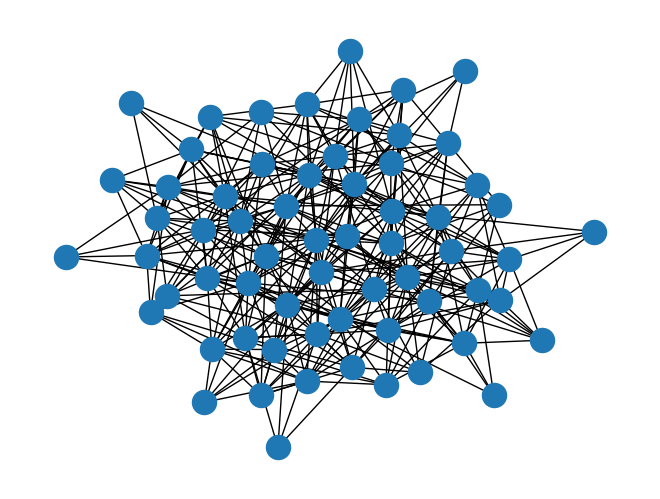

In [47]:
mpl_draw(G)

In [48]:
def generate_percolation_graph(p,generator,dim):
    r"""
    Generates a percolation graph with bond acceptance probability p,
    with the dense graph being defined by the function `generator`. This
    function will be called with the `dim` keyword. That seems like silly
    design? Maybe? The idea is that the structure is defined by `generator`,
    and the size of the structure is defined by `dim`. Obviously, `dim` and
    `generator` need to play nicely together so this maybe isn't very 
    end-user friendly.
    """
    G = generator(dim).copy()
    marked_edges = [edge if p < rand() else -1 for edge in G.edge_list()]
    remove_list = [x for x in marked_edges if x != -1] if -1 in marked_edges else marked_edges
    G.remove_edges_from(remove_list)
    return G

def generate_percolation_graph_quantum(sigma,generator,dim):
    r"""
    Generates a percolation graph with disorder strength sigma, the std
    of a normal distribution.
    
    The dense graph is defined by the function `generator`. This
    function will be called with the `dim` keyword to determine its size, so these
    should be paired together.
    """
    G = generator(dim).copy() # avoid potentially mutating the original
    
    # get each edge's coupling strength, J, and compute the mean hopping prob
    # for the given sigma. Then, randomly keep the bond with that probability, otherwise
    # we mark it for deletion. 
    remove_list = [edge for edge, J in zip(G.edge_list(),G.edges()) if mean_hopping_prob(sigma,J) < rand()]
    
    # remove and return
    G.remove_edges_from(remove_list)
    return G

def avg_cluster_size(p, dim, generator=grid_graph, repititions=100):
    r"""
    For a square graph of L*L nodes, compute the average cluster size,
    excluding the largest cluster. As L->infinity, this ensures that this
    function diverges at the phase transition, but nowhere else.
    """
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    counts = np.zeros(sites+1,dtype=np.int64)
    for _ in range(repititions):
        G = generate_percolation_graph(p,generator,dim)
        comps = rx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))  
      
    return (bins**2 @ counts) / (bins@counts) if bins @ counts != 0 else 0

def percolation_strength(p,dim,generator=grid_graph,repititions=100):
    r"""
    For a square graph of L*L nodes, compute the percolation strength,
    which is the proportion of the graph belonging to the largest cluster,
    which should be the order paramater of the phase tranistion as L->infinity
    """
    P = 0
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    for _ in range(repititions):
        G = generate_percolation_graph(p,generator,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
    return P/repititions

def cluster_size_and_strength(p,dim,generator=grid_graph,repititions=100):
    r"""
    return both the percolation strength and the average cluster size
    for the square L*L percolation graph as a tuple (size, strength)
    """
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    counts = np.zeros(sites+1,dtype=np.int64)
    P = 0
    for _ in range(repititions):
        G = generate_percolation_graph(p,generator,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
        temp_counts = np.bincount([len(comp) for comp in rx.connected_components(G)],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts), P


def avg_cluster_size_quantum(sigma, dim, generator=grid_graph, repititions=100):
    r"""
    wirds
    """
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    counts = np.zeros(sites+1,dtype=np.int64)
    for _ in range(repititions):
        G = generate_percolation_graph_quantum(sigma,generator,dim)
        comps = rx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts) if bins @ counts != 0 else 0

def percolation_strength_quantum(sigma,dim,generator=grid_graph,repititions=100):
    r"""
    thots
    """
    P = 0
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    for _ in range(repititions):
        G = generate_percolation_graph_quantum(sigma,generator,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
    return P/repititions

In [155]:
r_list = [6,8,10,12]
pvals = np.arange(.05,.35,.01)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size(p,r,generator=get_fcc_graph,repititions=reps) for p in pvals]
    strength[r] = [percolation_strength(p,r,generator=get_fcc_graph,repititions=reps) for p in pvals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(pvals))} s")

Avg Computation time per fcc graph for r=6 is 0.007334620873133342 s
Avg Computation time per fcc graph for r=8 is 0.017043627977371217 s
Avg Computation time per fcc graph for r=10 is 0.034348076025644936 s
Avg Computation time per fcc graph for r=12 is 0.05678582827250163 s


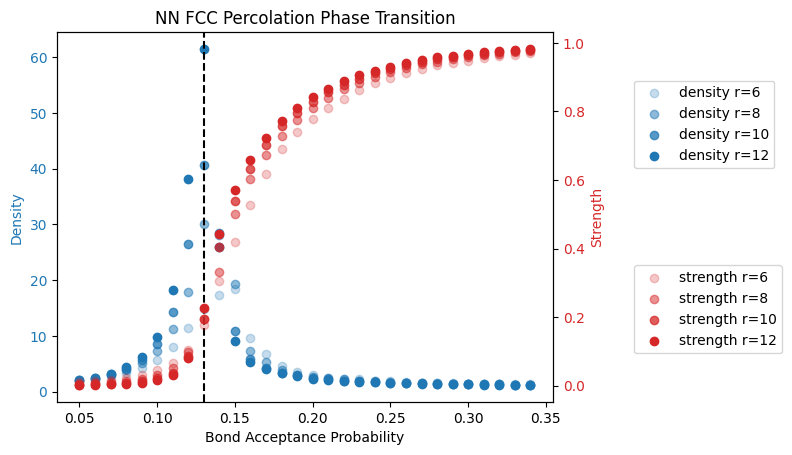

In [165]:
fig, ax1 = plt.subplots()
max_density_pval=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Bond Acceptance Probability')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(pvals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_pval=pvals[np.argmax(density[r])]
        max_density = np.max(density[r])
    
    
ax1.axvline(x=max_density_pval, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(pvals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NN FCC Percolation Phase Transition")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [220]:
r_list = [6,8,10,12]
pvals = np.arange(.05,.35,.01)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size(p,r,generator=get_nnn_fcc_graph,repititions=reps) for p in pvals]
    strength[r] = [percolation_strength(p,r,generator=get_nnn_fcc_graph,repititions=reps) for p in pvals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(pvals))} s")

Avg Computation time per fcc graph for r=6 is 0.01790324854850769 s
Avg Computation time per fcc graph for r=8 is 0.06621522609392802 s
Avg Computation time per fcc graph for r=10 is 0.19174967098236084 s
Avg Computation time per fcc graph for r=12 is 0.4910320816834768 s


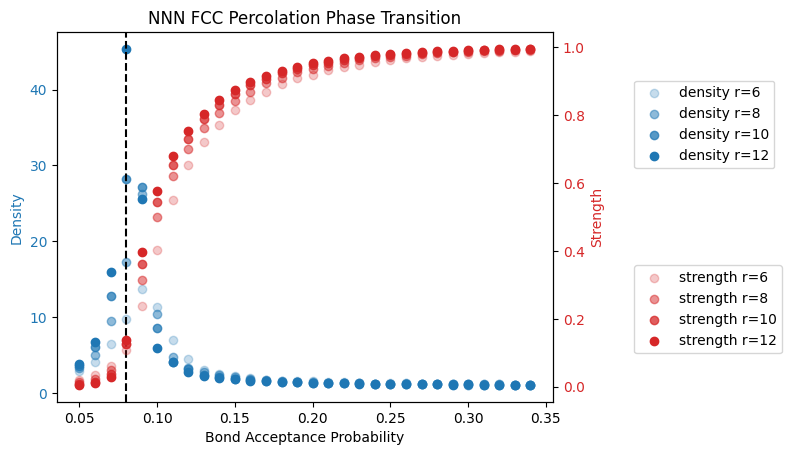

In [ ]:
fig, ax1 = plt.subplots()
max_density_pval=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Bond Acceptance Probability')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(pvals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_pval=pvals[np.argmax(density[r])]
        max_density = np.max(density[r])

    
ax1.axvline(x=max_density_pval, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(pvals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NNN FCC Percolation Phase Transition")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

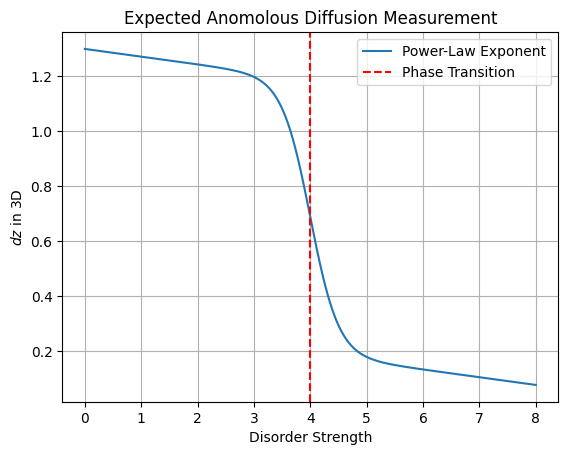

In [31]:
import numpy as np

import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(0, 8, 400)

# Generate y values using the tanh function
y = 1*(np.tanh( (4 - x) * 2)+1)/2 + (1.5-.14*x)/5

# Create the plot
plt.plot(x, y, label='Power-Law Exponent')
plt.axvline(x=4, color='r', linestyle='--', label='Phase Transition')
plt.xlabel('Disorder Strength')
plt.ylabel(r'$dz$ in 3D')
plt.title('Expected Anomolous Diffusion Measurement')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
maxes = {}

In [19]:
r_list = [6,8,10,12]
sig_vals = np.arange(.1,10,.1)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size_quantum(sigma,r,generator=get_fcc_graph,repititions=reps) for sigma in sig_vals]
    strength[r] = [percolation_strength_quantum(sigma,r,generator=get_fcc_graph,repititions=reps) for sigma in sig_vals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s")

Avg Computation time per fcc graph for r=6 is 0.00851292306726629 s


/tmp/ipykernel_1639/473581264.py:126: RuntimeWarning: invalid value encountered in scalar divide
  return (bins**2 @ counts) / (bins@counts)


Avg Computation time per fcc graph for r=8 is 0.02080963214238485 s
Avg Computation time per fcc graph for r=10 is 0.04035428817826088 s
Avg Computation time per fcc graph for r=12 is 0.06844964311580465 s


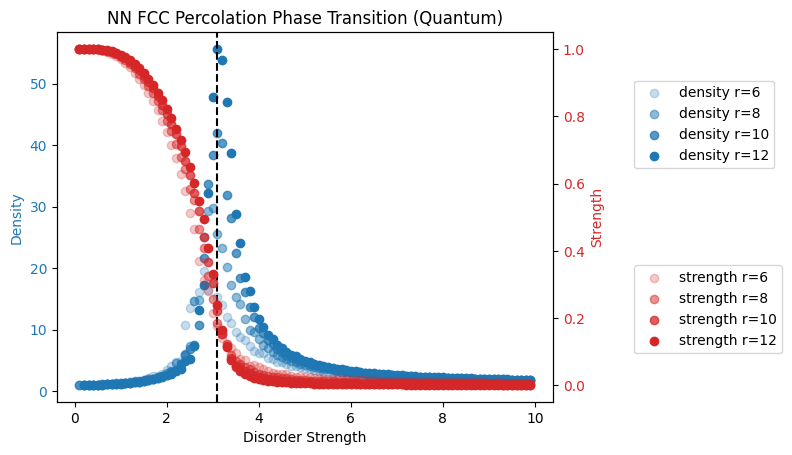

In [20]:
fig, ax1 = plt.subplots()
max_density_sigma=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Disorder Strength')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(sig_vals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_sigma = sig_vals[np.argmax(density[r])]
        max_density = np.max(density[r])
maxes[1]=[max_density_sigma,max_density]
    
ax1.axvline(x=max_density_sigma, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(sig_vals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NN FCC Percolation Phase Transition (Quantum)")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [27]:
r_list = [6,8,10,12]
sig_vals = np.arange(.1,10,.1)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size_quantum(sigma,r,generator=get_nnn_fcc_graph,repititions=reps) for sigma in sig_vals]
    strength[r] = [percolation_strength_quantum(sigma,r,generator=get_nnn_fcc_graph,repititions=reps) for sigma in sig_vals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s")

Avg Computation time per fcc graph for r=6 is 0.012028833880568995 s
Avg Computation time per fcc graph for r=8 is 0.030353119084329316 s
Avg Computation time per fcc graph for r=10 is 0.059304552608066136 s
Avg Computation time per fcc graph for r=12 is 0.1014266020601446 s


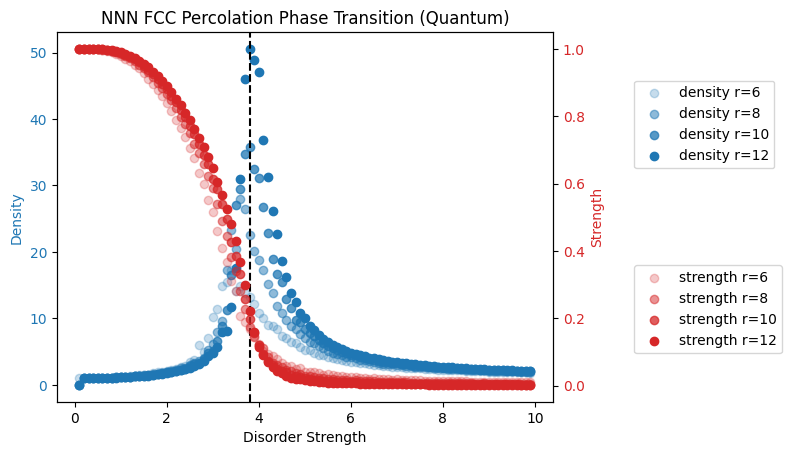

In [28]:
fig, ax1 = plt.subplots()
max_density_sigma=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Disorder Strength')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(sig_vals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_sigma = sig_vals[np.argmax(density[r])]
        max_density = np.max(density[r])
        
maxes[2]=[max_density_sigma,max_density]
ax1.axvline(x=max_density_sigma, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(sig_vals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NNN FCC Percolation Phase Transition (Quantum)")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [29]:
maxes

{1: [np.float64(3.1), np.float64(41.98196276561633)],
 2: [np.float64(3.8000000000000003), np.float64(50.539449867370514)]}

In [31]:
r_list = [6,8,10,12]
sig_vals = np.arange(.1,10,.1)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size_quantum(sigma,r,generator=get_nnnn_fcc_graph,repititions=reps) for sigma in sig_vals]
    strength[r] = [percolation_strength_quantum(sigma,r,generator=get_nnnn_fcc_graph,repititions=reps) for sigma in sig_vals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s")

Avg Computation time per fcc graph for r=6 is 0.01655354078369911 s
Avg Computation time per fcc graph for r=8 is 0.0399613542990251 s
Avg Computation time per fcc graph for r=10 is 0.07861998967450075 s
Avg Computation time per fcc graph for r=12 is 0.13756239565936002 s


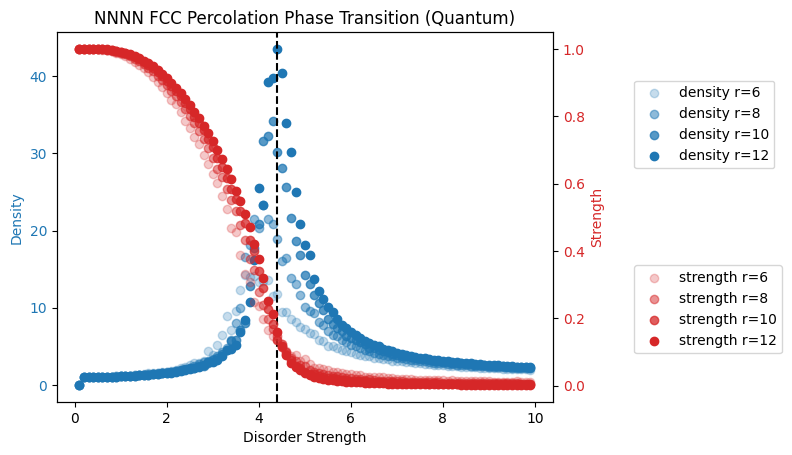

In [32]:
fig, ax1 = plt.subplots()
max_density_sigma=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Disorder Strength')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(sig_vals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_sigma = sig_vals[np.argmax(density[r])]
        max_density = np.max(density[r])
    
maxes[3]=[max_density_sigma,max_density]  
ax1.axvline(x=max_density_sigma, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(sig_vals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NNNN FCC Percolation Phase Transition (Quantum)")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [58]:
r_list = [6,8,10,12,14]
sig_vals = np.arange(.1,6,.05)

generator = lambda r : get_graph(r,fmt="fcc_n5_",generator=generate_fcc_n5)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size_quantum(sigma,r,generator=generator,repititions=reps) for sigma in sig_vals]
    strength[r] = [percolation_strength_quantum(sigma,r,generator=generator,repititions=reps) for sigma in sig_vals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s")

Avg Computation time per fcc graph for r=6 is 0.016427387928558607 s
Avg Computation time per fcc graph for r=8 is 0.0412472668138601 s
Avg Computation time per fcc graph for r=10 is 0.0818970354128692 s
Avg Computation time per fcc graph for r=12 is 0.14422287114595964 s
Avg Computation time per fcc graph for r=14 is 0.7344477140297324 s


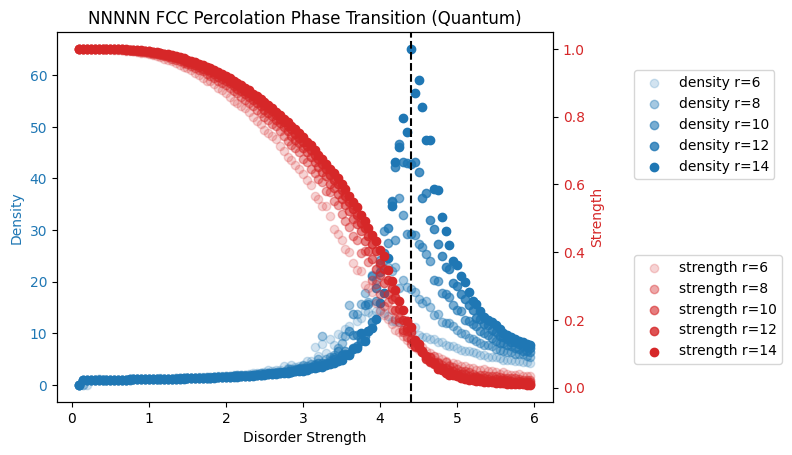

In [59]:
fig, ax1 = plt.subplots()
max_density_sigma=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Disorder Strength')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(sig_vals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_sigma = sig_vals[np.argmax(density[r])]
        max_density = np.max(density[r])
    
maxes[4] = [max_density_sigma,max_density]
ax1.axvline(x=max_density_sigma, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(sig_vals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NNNNN FCC Percolation Phase Transition (Quantum)")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [49]:
r_list = [6,8,10,12]
sig_vals = np.arange(.1,10,.1)

generator = lambda r : get_graph(r,fmt="fcc_n6_",generator=generate_fcc_n6)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size_quantum(sigma,r,generator=generator,repititions=reps) for sigma in sig_vals]
    strength[r] = [percolation_strength_quantum(sigma,r,generator=generator,repititions=reps) for sigma in sig_vals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s")

KeyboardInterrupt: 

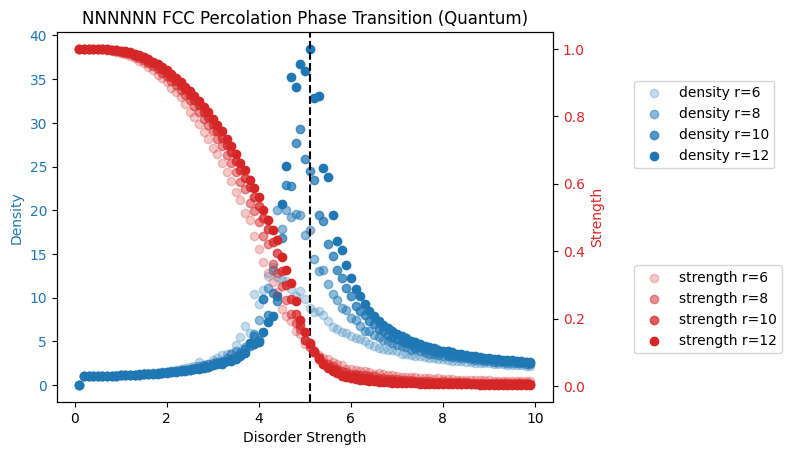

In [ ]:
fig, ax1 = plt.subplots()
max_density_sigma=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Disorder Strength')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(sig_vals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_sigma = sig_vals[np.argmax(density[r])]
        max_density = np.max(density[r])
    
maxes[5]=[max_density_sigma,max_density]  
ax1.axvline(x=max_density_sigma, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(sig_vals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NNNNNN FCC Percolation Phase Transition (Quantum)")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [50]:
r_list = [6,8,10,12]
sig_vals = np.arange(.1,10,.1)

generator = lambda r : get_graph(r,fmt="fcc_n7_",generator=generate_fcc_n7)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size_quantum(sigma,r,generator=generator,repititions=reps) for sigma in sig_vals]
    strength[r] = [percolation_strength_quantum(sigma,r,generator=generator,repititions=reps) for sigma in sig_vals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s")

Avg Computation time per fcc graph for r=6 is 0.035840303368038604 s
Avg Computation time per fcc graph for r=8 is 0.09074165476693047 s
Avg Computation time per fcc graph for r=10 is 0.18072270073071875 s
Avg Computation time per fcc graph for r=12 is 0.3208254733952609 s


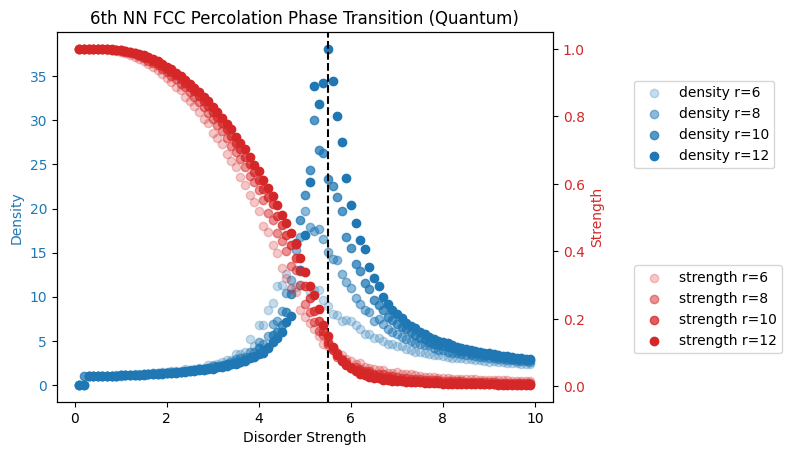

In [52]:
fig, ax1 = plt.subplots()
max_density_sigma=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('Disorder Strength')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(sig_vals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_sigma = sig_vals[np.argmax(density[r])]
        max_density = np.max(density[r])
    
#maxes[6]=[max_density_sigma,max_density]  
ax1.axvline(x=max_density_sigma, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(sig_vals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("6th NN FCC Percolation Phase Transition (Quantum)")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()

In [55]:
Jmins = [1,.32,.19,.136,.125,.064]

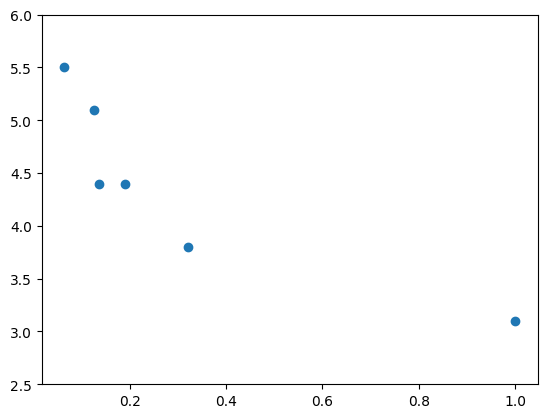

In [67]:
plt.scatter(Jmins,np.array(list(maxes.values())).T[0])
plt.ylim([2.5,6])
plt.show()

In [70]:
neighbors = [len(nn_adjacency),len(nnn_adjacency),len(nnnn_adjacency),len(n5_adjacency),len(n6_adjacency),len(n7_adjacency)]

In [71]:
running_total_neighbors = np.cumsum(neighbors)
running_total_neighbors

array([12, 18, 24, 26, 38, 56])

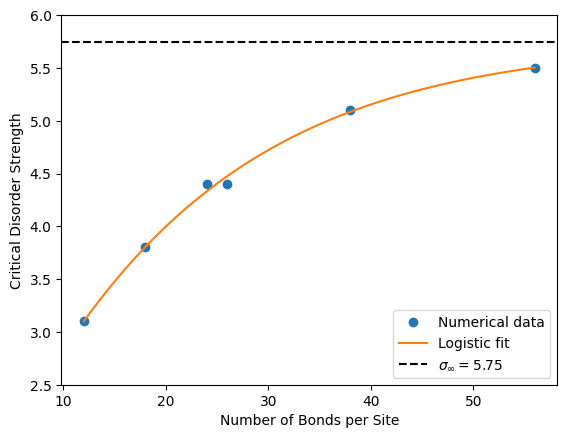

In [92]:
from scipy.optimize import curve_fit

x = running_total_neighbors
y = np.array(list(maxes.values())).T[0]

def logistic_growth(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

popt, pcov = curve_fit(logistic_growth, x, y, p0=[max(y), np.median(x), 1, min(y)])

x_fit = np.linspace(min(x), max(x), 100)
y_fit = logistic_growth(x_fit, *popt)

plt.plot(x, y, 'o', label='Numerical data')
plt.plot(x_fit, y_fit, '-', label='Logistic fit')
sig_inf = round(popt[0] + popt[3],2)
plt.axhline(y=sig_inf, color='black', linestyle='--', label=r"$\sigma_{\infty}=$"+f'{sig_inf}')
plt.ylim([2.5, 6])
plt.xlabel("Number of Bonds per Site")
plt.ylabel("Critical Disorder Strength")
plt.legend()
plt.show()

In [79]:
popt

array([ 27.26939817, -27.70806909,   0.05615087, -21.52018778])

In [87]:
(np.sqrt(3)/2)*5.75/1.02

np.float64(4.882005952706394)

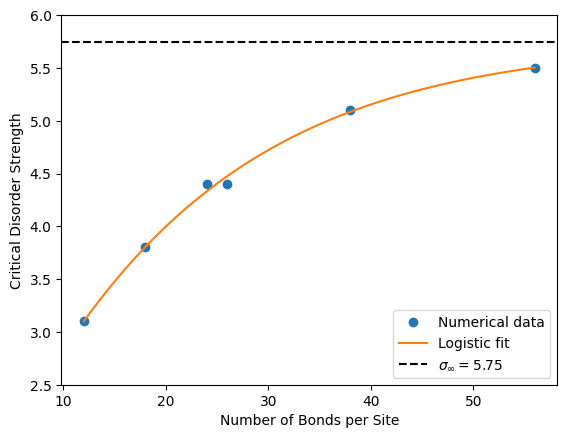

In [93]:
from scipy.optimize import curve_fit

x = running_total_neighbors
y = np.array(list(maxes.values())).T[0]

def logistic_growth(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

popt, pcov = curve_fit(logistic_growth, x, y, p0=[max(y), np.median(x), 1, min(y)])

x_fit = np.linspace(min(x), max(x), 100)
y_fit = logistic_growth(x_fit, *popt)

plt.plot(x, y, 'o', label='Numerical data')
plt.plot(x_fit, y_fit, '-', label='Logistic fit')
sig_inf = round(popt[0] + popt[3], 2)
plt.axhline(y=sig_inf, color='black', linestyle='--', label=r"$\sigma_{\infty}=$"+f'{sig_inf}')
plt.ylim([2.5, 6])
plt.xlabel("Number of Bonds per Site")
plt.ylabel("Critical Disorder Strength")
plt.legend()
plt.show()

In [94]:
print("Hello, World!")

Hello, World!
